### 把后验估计取出来

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import functools
import copy
import pickle

from jax_cfd_test import my_equations
from jax_cfd_test import my_funcutils
from jax_cfd_test import my_forcing

from flax import linen as nn
from jax import random, numpy as jnp
from jax import grad

import optax

import time
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion5(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion5(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    

In [ ]:
# 规划：
'''
1，涉及需要导数的过程都需要封装。因此 forward，likelihood，posterior，kld 都需要封装起来
2，其他的更新参数过程可以外方面
'''
def log_normalize_pdf(log_probs):
    # 计算最大对数概率值
    max_log_prob = jnp.max(log_probs)
    
    # 缩放并转换对数概率到概率空间，减少数值溢出风险
    probs = jnp.exp(log_probs - max_log_prob)
    
    # 归一化概率值
    normalized_probs = probs / jnp.sum(probs)
    
    # 转换回对数空间
    normalized_log_probs = jnp.log(normalized_probs+1e-32)
    
    return normalized_log_probs

def normalize_pdf(probs):
    return probs/jnp.sum(probs)

def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
    #key, subkey = random.split(key) 这一步放在外面
        
    #暂时只考虑不要误差的情况：
    observation = output_point + jnp.array([0.0])
    #这是要误差的代码：
    #noise = random.normal(key,(1,1))*(noise_base_scale+jnp.abs(output_point)*noise_ratio_scale) #形状(1,1)
    #observation = output_point + noise*0.05
    # 给一个函数，从所有的输出中找到关心的点
    false_center = jnp.array([1.0,1.0]) - d_start
    false_start = jnp.array([0.5, 0.5])
    _, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
    #_, output_all = sealed_convection_diffusion_true(false_start, false_center, stage) #这里的形状是()
    output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
    # 取出[0,1]^2之间的矩阵
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
    output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*jnp.abs(output_for_xb))
    return loglikelihood

def calculate_info_gain(prior, posterior):
    '''
    KLD
    '''
    return jnp.sum(posterior*(jnp.log(posterior+1e-32) - jnp.log(prior+1e-32)))

def forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    evidence_list = jnp.exp(log_evidence_list)
    posterior = evidence_list/jnp.sum(evidence_list)
    KLD = calculate_info_gain(prior, posterior)
    return KLD, posterior

def compute_gradient_norm(grad_params):
    # 计算所有参数梯度的平方L2范数
    squared_norms = jax.tree_util.tree_map(lambda x: jnp.sum(x**2), grad_params)
    # 求和所有平方范数
    total_squared_norm = sum(jax.tree_util.tree_leaves(squared_norms))
    # 取平方根得到总的L2范数
    total_norm = jnp.sqrt(total_squared_norm)
    return total_norm

'''
main
'''

# 输入权重，求权重的导数

# PDE settings =================
size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.



key = random.PRNGKey(0)  # 随机数生成器的键
x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  # 输入层到隐藏层1，8个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x)  # 隐藏层1到隐藏层2，4个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x)  # 隐藏层2到输出层，1个节点
        return x
        
model = localFullyConnectedNN2()  # 创建模型实例


params = {'params': {'Dense_0': {'bias': jnp.array([-0.5034, -0.0280, -0.3198,  0.4847]),
           'kernel': jnp.array([[ 4.8153,  4.1794,  8.2351,  9.6484],
        [-2.8456,  5.2352, -8.0220, -9.1204]])},
          'Dense_1': {'bias': jnp.array([-0.4493,  1.2653,  1.2336,  0.4221]),
           'kernel': jnp.array([[-0.7218,  2.8800,  3.2308,  1.1351],
        [-5.0888,  4.8622,  4.7844,  5.0217],
        [-2.9412,  3.9048, -4.2149, -5.2085],
        [ 4.3755, -3.2684,  4.4775,  3.3922]])},
          'Dense_2': {'bias': jnp.array([-0.3442]),
           'kernel': jnp.array([[-10.5900],
        [ 10.0693],
        [-10.0099],
        [-10.6412]])}}
         }


params_back = copy.deepcopy(params)

# OED settings =================
n_stage = 5
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.25,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

key = random.split(key,int(n_stage*2+1))

    
def loss_param_refine5(current_params, d_start, stage, estimated_center, model, observation):

    y_f, _ = sealed_convection_diffusion_nn(current_params, d_start, estimated_center, stage, model)
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale* jnp.abs(y_f))

    return -loglikelihood


def loss_design(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key, model):
    KLD, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    return -KLD


iteration_step_number1 = tuple((50,45,40,40,40,40,40,40,40,40,40,40,40,30,20))
iteration_step_number2 = tuple((10,80,80,80,80,80,80,80,80,80,80,80,80,80,100))
stage_to_skip = [0]

fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

learning_rate1 = 0.003
learning_rate2 = jnp.ones(n_stage)*0.012

print('Network Settings: \n')
print(f'learning_rate1 = ', learning_rate1)
print(f'learning_rate2 = ', learning_rate2)
print(f'iteration_step_number1 = ', iteration_step_number1)
print(f'iteration_step_number2 = ', iteration_step_number2)

    
decay_rate1 = 1.0
decay_rate2 = 0.9  # 衰减率

learning_rate1_min = 0.001
learning_rate2_min = 0.001



KLD_list=[]
evidence_list=[]
NN_error_list=[]
gradient_norm_list=[]
params_list=[]
design_list = []
design_list.append(d_start)
posterior_list = []
posterior_oed_list = []
estimated_posterior_point = []

In [ ]:
for stage in range(n_stage):
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
    
    clip_count = 0
    
    if stage!=0:
        del tx1
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    tx1 = optax.chain(
    optax.adam(learning_rate1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")

    #if stage!=0:
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior
    prior = posterior
    posterior_oed_list.append(posterior)

    design_list.append(d_start)
    
    if stage!=0:
        del tx2
        del opt_state2
        
    tx2 = optax.adam(learning_rate2[stage])
    
    opt_state2 = tx2.init(params)

    start_time = time.time()

    # 估计后验中心
    num_top = 5
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    
    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    estimated_center = jnp.array([average_x, average_y])/50
    print(f'estimated_center is ', estimated_center)
    estimated_posterior_point.append(estimated_center)
        

    print(f'design from OED is {d_start}')
    if stage == 2:
        d_start = d_start + jnp.array([0.05,-0.05])

    
    print(f'design for model correction is {d_start}')
    observation, _ = sealed_convection_diffusion_true(d_start, center, stage)
    print(f'measurement is: {observation}')

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start, stage, estimated_center_perturbed, model, observation)

        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state2 = tx2.update(clipped_grads, opt_state2, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        #print(f'Loss step {i} max evidence items: {max_evidence_items}, nn error {i}: {net_accuracy}')
        
        if np.isnan((max_evidence_items)).any():
            print('some results are Nan')
            break
            
        evidence_list.append(-max_evidence_items)

        
    params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    if stage not in stage_to_skip:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        if stage!=0:
             del prior
        prior = posterior
        
    posterior_list.append(posterior)

    
    #恢复design到原来的轨迹
    #if stage in [2]:
    d_start = design_list[-1]
        
    
    axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([d_start[0],d_start_backup[0]],
                    [d_start[1],d_start_backup[1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    axes[stage].set_xlabel('z_x')  # 设置x轴标签
    axes[stage].set_ylabel('z_y')  # 设置y轴标签



plt.tight_layout()  # 调整子图间距
plt.show()

In [ ]:
import numpy as np
import jax.numpy as jnp


n_stage =5
local_size = 51
center = jnp.array([0.25,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(1, 5, figsize=(4.03*5, 3.5))
fig.subplots_adjust(wspace=0.21)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.6:
        return '0.6   '  # 向左移动
    elif x == 0.3:
        return '0.3'
    else:
        return f'{x:.2f}'


for stage in [0,1,2,3,4]:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')

    if stage == 2:
        axes[pic_num].scatter(d_start[0]+0.05, d_start[1]-0.05, marker='^', s=100, c='blue')
    
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    axes[pic_num].set_title(f'stage {stage+1}', fontsize=fontsize)  # 设置子图的标题
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  # 设置x轴标签
    axes[pic_num].set_yticks([0.0, 0.3,0.6])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.0,0.3,0.6])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.0,0.6])
    axes[pic_num].set_ylim([0.0,0.6])
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])

contour_set.set_clim(0, 0.45)
ticks = [0, 0.15, 0.30, 0.45]

cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='current measure place')

plt.plot([], [], marker='^', markersize=10, color='b', linestyle='None', label='better measure place')

legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")


#plt.savefig('NN case good design.png',bbox_inches='tight')

In [86]:
np.max(posterior_list[2])

0.3142578

In [8]:
#读取数据
with open('all_data_nn_case_data_6_test11.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]

In [6]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point
}

with open('all_data_nn_case_data_6_test11.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

#test1 不对design做修改
#test2 是对design做了修改
#test3 不做correction

#更正了似然函数的计算公式
#test5 单纯model correction 原本的学习陷入局部最小值
#test6 不做model correction                                 # 使用的数据
#test7 单纯model correction 增大扰动值为0.05 使用线性衰减
#test8 第二步改了设计
#test9 单纯model correction 使用大扰动加大的衰减              # 使用的数据
#test10 第三步改了设计，但是后验变化不大
#test11 第二步改了设计                                       # 使用的数据
#test12 用所有点

In [8]:
def show_nn_trajectory(params_list, apply_model, colormap = 'Blues', center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(10, 5))
    
    cmap = plt.colormaps[colormap].resampled(len(params_list)+2)#cm.get_cmap('Blues', len(params_list))
    for index, params in enumerate(params_list):
        #if index not in [6]:
        #    continue
        array_nn = apply_model.apply(params, xy_combined) #* 100.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}',
                 color=cmap(index+1))
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), color='r', linestyle = '--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), color='g', label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    

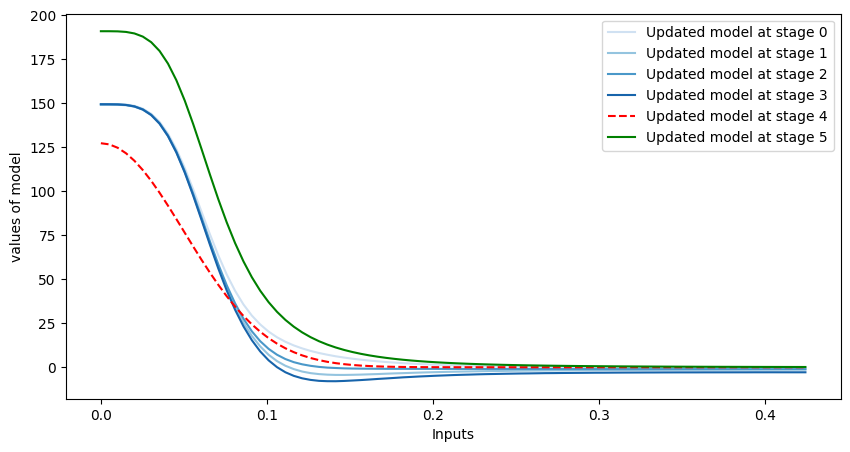

In [ ]:
#show_nn_trajectory(params_list, model, center_x=0, center_y=0, size=85)
show_nn_trajectory(params_list[:-1], model, center_x=0, center_y=0, size=85)

plt.legend()

leg = plt.gca().get_legend()

new_labels = ['Updated model at stage 0', 'Updated model at stage 1','Updated model at stage 2','Updated model at stage 3','Updated model at stage 4','Updated model at stage 5', 'Updated model at stage 6','System', 'Baseline model']

for text, new_label in zip(leg.get_texts(), new_labels):
    text.set_text(new_label)

plt.draw()

In [ ]:
# EKI

In [5]:
import os
import pickle
import re
import gc
from flax.traverse_util import flatten_dict, unflatten_dict

def reconstruct_array_to_dict(params_grad_array, grads):
    """
    将扁平化后的数组重新构建回原始的 grads 字典。

    参数:
    - params_grad_array: 扁平化后的梯度数组
    - grads: 原始的 grads 字典，用于获取结构信息

    返回:
    - reconstructed_grads: 重建后的 grads 字典
    """
    # 获取原始 grads 的结构信息
    params_grad_flat = flatten_dict(grads)
    shapes = {k: v.shape for k, v in params_grad_flat.items()}

    # 将 params_grad_array 拆分成原始形状的数组
    index = 0
    reconstructed_params_grad_flat = {}
    for k, shape in shapes.items():
        size = size = int(np.prod(shape))  # 将形状转换为 numpy 数组，然后计算其大小
        reconstructed_params_grad_flat[k] = jnp.reshape(params_grad_array[index:index+size], shape)
        index += size

    # 将平坦化的字典恢复到原始的嵌套结构
    reconstructed_grads = unflatten_dict(reconstructed_params_grad_flat)

    return reconstructed_grads

def reconstruct_dict_to_array(grads):
    """
    将嵌套字典转换为扁平化的数组。

    参数:
    - grads: 嵌套的 grads 字典

    返回:
    - params_grad_array: 扁平化后的梯度数组
    """
    # 将字典展平
    params_grad_flat = flatten_dict(grads)
    
    # 获取所有梯度值，并将其展平
    flat_arrays = [jnp.ravel(v) for v in params_grad_flat.values()]
    
    # 将所有展平的数组拼接成一个单独的数组
    params_grad_array = jnp.concatenate(flat_arrays)
    
    return params_grad_array
    
def kl_divergence(mu1, sigma1, mu2, sigma2):
    # 计算逆矩阵和行列式
    sigma2_inv = jnp.linalg.inv(sigma2)
    #sigma1_det = jnp.linalg.det(sigma1)
    #sigma2_det = jnp.linalg.det(sigma2)
    
    # 计算各项
    term1 = jnp.trace(sigma2_inv @ sigma1)
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)
    
    _, logdet_sigma1 = jnp.linalg.slogdet(sigma1)
    _, logdet_sigma2 = jnp.linalg.slogdet(sigma2)
    term3 = logdet_sigma2 - logdet_sigma1
    #term3 = jnp.log(sigma2_det / sigma1_det)
    
    # 计算最终的KL散度
    kl_div = 0.5 * (term1 + term2 - len(mu1) + term3)
    
    return kl_div
    

    

# 现在需要一个函数，对于一个给定的场，给出一些index，取出/插值这些index上的点
def insert_from_u(u,indexs):
    # 要求indexs是一个数组，design_number * 2 / 或者一个列表
    y_f_member = jnp.zeros((1, len(indexs)))
    for i in range(len(indexs)):
        y_f = jax.scipy.ndimage.map_coordinates(u,indexs[i],1)
        y_f_member = y_f_member.at[0,i].set(y_f)

    return y_f_member

#indexs=np.array([[111,111],
#                [112,113]])
#insert_from_u(output_all, indexs)

#import numpy as np

def generate_2d_grid(lower_limit, upper_limit, num_points):
    # 在两个方向上生成指定数量的点
    x = np.linspace(lower_limit, upper_limit, num_points)
    y = np.linspace(lower_limit, upper_limit, num_points)
    
    # 生成网格
    X, Y = np.meshgrid(x, y)
    
    # 将网格点坐标转换为n*2的数组
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    
    return grid_points

#def generate_2d_grid_xy(x_mid, y_mid, space, num=3):
#    # 在两个方向上生成指定数量的点
#    x = np.array([x_mid-space, x_mid, x_mid+space])
#    y = np.array([y_mid-space, y_mid, y_mid+space])
#    
#    # 生成网格
#    X, Y = np.meshgrid(x, y)
#    
#    # 将网格点坐标转换为n*2的数组
#    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
#    
#    return grid_points

## 示例使用
#lower = 110
#upper = 130
#num = 5
#grid = generate_2d_grid(lower, upper, num)
#print(grid)

def generate_2d_grid_xy(x_mid, y_mid, space, num=3):
    # 检查num是否为奇数，如果不是则加1使其为奇数
    if num % 2 == 0:
        raise ValueError("num必须是奇数")

    # 生成x方向的点，确保中点位于x_mid
    x = np.linspace(x_mid - space * (num // 2), x_mid + space * (num // 2), num)
    
    # 生成y方向的点，确保中点位于y_mid
    y = np.linspace(y_mid - space * (num // 2), y_mid + space * (num // 2), num)
    
    # 生成网格
    X, Y = np.meshgrid(x, y)
    
    # 将网格点坐标转换为n*2的数组
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    
    return grid_points
    

In [6]:
def generate_sample(key, mean, std_dev):
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
    
def natural_key(filename):
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', filename)]

# 保存检查点的函数
def save_checkpoint(i, j, params_trajectory, ensemble_members_array):
    checkpoint = {
        'i': i,
        'j': j,
        'params_trajectory': params_trajectory,
        'ensemble_members_array': ensemble_members_array
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_i_{i}_j_{j}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint saved at i={i}, j={j}")

# 加载最近的检查点
def load_checkpoint(j):
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(f'_j_{j}.pkl')], key=natural_key)
    if checkpoint_files:
        latest_checkpoint = checkpoint_files[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        print(f"Checkpoint loaded from {latest_checkpoint}")
        return checkpoint
    return None

def EnKF_process_multidata(indexs, observation, ensemble_member, estimated_center, stage, model, key2, step_index, num_top=5):
    
    ensemble_size_local = ensemble_member.shape[0]
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]

    observe_size = len(indexs)
    y_fs = jnp.zeros((ensemble_size_local,observe_size))

    # vmap forward
    batch_size = 20

    # single-member prediction
    def process_one(member):
        member_dict = reconstruct_array_to_dict(member, params)
        _, u = sealed_convection_diffusion_nn(member_dict,
                                              d_start,
                                              estimated_center,
                                              stage,
                                              model)   # u.shape == (251, 251)
        y = insert_from_u(u, indexs).squeeze()  # shape == (observe_size,)
        return y

    # vectorize over a batch of members
    process_batch = jax.vmap(process_one, in_axes=0)

    # compute in batches of 50, serially accumulating into y_fs
    for start in range(0, ensemble_size_local, batch_size):
        end = min(start + batch_size, ensemble_size_local)
        batch = ensemble_member[start:end]         # shape (<=50, param_dim)
        y_batch = process_batch(batch)            # shape (<=50, observe_size)
        y_fs = y_fs.at[start:end, :].set(y_batch)
        print('.', end='')

    ## sequential forward
    #for i in range(ensemble_size_local):
    #    ensemble_member_dict = reconstruct_array_to_dict(ensemble_member[i],params)
    #    _, u  = sealed_convection_diffusion_nn(ensemble_member_dict, d_start, estimated_center, stage, model) # u的尺寸是251*251
    #    y_f_member = insert_from_u(u,indexs)
    #    y_fs = y_fs.at[i,:].set(y_f_member.squeeze())
    #    print('.',end='')
        
    
    y_f_mean = np.mean(y_fs, axis=0).reshape(1,-1)
    
    noise_covariance_matrix = np.eye(observe_size) * noise_base_scale
    P_yy = 1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean)) + noise_covariance_matrix

    #x_f_theta = ensemble_member.reshape(ensemble_size_local,-1) # 这一步是对于1维情况准备的，高维情况不用reshape
    x_f_theta = ensemble_member
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = np.matmul(P_xy, np.linalg.inv(P_yy))

    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T

    #x_a_mean = np.mean(x_a, axis=0)
    #inflation_factor = 1.001 # 或其他合适的值
    #x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


with open('all_data_nn_case_data_6_test9.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]


stage = 2
grid_size=50
ensemble_size = 300  # 生成的数组数量
ensemble_step = 10


std_dev = 0.3  #0.05  #0.1  # 标准差

key_ensemble = jax.random.PRNGKey(0)  # 随机数种子
keys_ensemble = jax.random.split(key_ensemble, ensemble_size)
key2 = jax.random.PRNGKey(2)  # 随机数种子

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  # 输入层到隐藏层1，8个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x)  # 隐藏层1到隐藏层2，4个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x)  # 隐藏层2到输出层，1个节点
        return x
        
model2 = localFullyConnectedNN2()  # 创建模型实例



estimated_center = estimated_posterior_point[stage]
print(f'estimated center is {estimated_center}')

#ensemble_optimizer = optax.adam(0.2)



noise_loc = 0
noise_base_scale = 0.005
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]




checkpoint_dir = './checkpoints/nn_case_data_6_EnFK_stage2_test21'
os.makedirs(checkpoint_dir, exist_ok=True)

d_start1 = design_list[stage+1]
d_start2 = design_list[stage+1]+jnp.array([0.05,-0.05])
d_start3 = design_list[stage+1]+jnp.array([-0.1,0.0])
d_start4 = jnp.array([0.2,0.2])
d_start5 = jnp.array([0.17,0.17])
d_start6 = jnp.array([0.35,0.15])
d_start8 = jnp.array([0.23,0.28])
d_start9 = jnp.array([0.17,0.12])

#key_for_ensemble = jax.random.split(key2,ensemble_step)

# 主循环
for j in [0,1]:#range(1):

    params = params_list[stage-1]

    
    mean_array = reconstruct_dict_to_array(params)

    ensemble_length=len(mean_array)

    # 初始化设计 d_start 根据 j 的值变化
    if j == 0:
        d_start = d_start1
    elif j == 1:
        d_start = d_start2
    

    
    #indexs = generate_2d_grid(110, 130, 10)
    #indexs = generate_2d_grid(105, 125, 21)

    indexs = generate_2d_grid_xy(d_start[0]*50+100, d_start[1]*50+100, 1)
        
    # 生辰观测数据
    _, ut  = sealed_convection_diffusion_true(d_start, center, stage) # u的尺寸是251*251
    observations = insert_from_u(ut,indexs)
    _, u0  = sealed_convection_diffusion_true(d_start, estimated_center, stage) # u的尺寸是251*251
    y0 = insert_from_u(u0,indexs)
     
        
    # 每次 j 切换时重新加载或初始化参数
    checkpoint = load_checkpoint(j)
    
    if checkpoint is not None:
        start_step = checkpoint['i']
        params_trajectory = checkpoint['params_trajectory']
        ensemble_members_array = checkpoint['ensemble_members_array']
        print(f'continue from design {j}, step {i}')
    else:
        start_step = 0
        # 初始化参数，在每次 j 切换时都要重新初始化
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, std_dev)
        params_trajectory = np.zeros((ensemble_step + 1, ensemble_size, ensemble_length))
        params_trajectory[0] = ensemble_members_array
        print(f'start from design {j}. step initial')



    for i in range(start_step, ensemble_step):
        key2 = jax.random.split(key2,1)[0]
        
        #observation_perturbed =  observations + 0.001 * jax.random.normal(key_for_ensemble[i], observations.shape)
        #ensemble_members_array = EnKF_process_multidata(indexs, observation_perturbed, ensemble_members_array, estimated_center, stage, model2, key2, i, num_top=5)
        
        ensemble_members_array = EnKF_process_multidata(indexs, observations, ensemble_members_array, estimated_center, stage, model2, key2, i, num_top=5)
        params_trajectory[i + 1] = ensemble_members_array
        print('|', end='')

        # 每10步保存一次检查点
        if (i + 1) % 5 == 0:
            save_checkpoint(i + 1, j, params_trajectory, ensemble_members_array)
    
    # 保存最终结果
    save_checkpoint(ensemble_step, j, params_trajectory, ensemble_members_array)
    print('-', end='')

    if j == 0:
        params_trajectory_good_design = params_trajectory
    elif j == 1:
        params_trajectory_bad_design = params_trajectory

print('saved in ', checkpoint_dir)

estimated center is [0.236      0.24800001]
start from design 0. step initial
...............|...............|...............|...............|...............|Checkpoint saved at i=5, j=0
...............|...............|...............|...............|...............|Checkpoint saved at i=10, j=0
Checkpoint saved at i=10, j=0
-start from design 1. step initial
...............|...............|...............|...............|...............|Checkpoint saved at i=5, j=1
...............|...............|...............|...............|...............|Checkpoint saved at i=10, j=1
Checkpoint saved at i=10, j=1
-saved in  ./checkpoints/nn_case_data_6_EnFK_stage2_test21


Checkpoint data loaded successfully.
Checkpoint data loaded successfully.
13.759285 82.48972


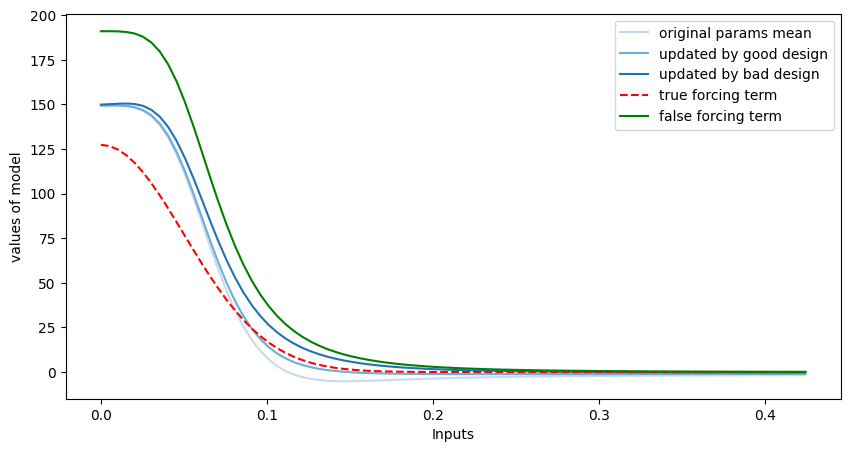

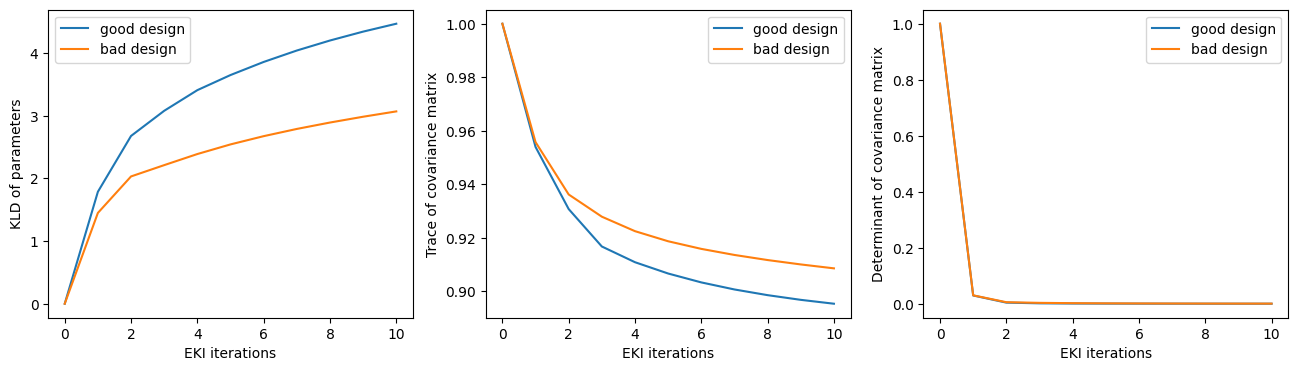

In [9]:
stage = 2
ensemble_step = 10
ensemble_size = 300

checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_0.pkl'

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_7 = checkpoint_data['params_trajectory'] # bad



checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_1.pkl' 

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_5 = checkpoint_data['params_trajectory'] # good



params0 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[0], axis=0),params)
params5 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[-1], axis=0),params)
params7 = reconstruct_array_to_dict(np.mean(result_matrix_design_7[-1], axis=0),params)
show_nn_trajectory([params0,params5, params7], model, 'Blues', center_x=0, center_y=0, size=85)
plt.legend()

leg = plt.gca().get_legend()

new_labels = ['original params mean', 'updated by good design', 'updated by bad design', 'true forcing term', 'false forcing term']

for text, new_label in zip(leg.get_texts(), new_labels):
    text.set_text(new_label)

plt.draw()


u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))


mean_ori = np.mean(result_matrix_design_5[0],axis=0)
mean_ori_centered = result_matrix_design_5[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory5 = np.zeros(ensemble_step+1)
kld_trajectory5[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before5 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_5 = np.zeros(ensemble_step+1)
covar_trace_5[0] = np.trace(var_ori)
covar_det_5 = np.zeros(ensemble_step+1)
covar_det_5[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_5[i],axis=0)
    mean_current_centered = result_matrix_design_5[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory5[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before5[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_5[i] = np.trace(var_current)
    covar_det_5[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


mean_ori = np.mean(result_matrix_design_7[0],axis=0)
mean_ori_centered = result_matrix_design_7[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory7 = np.zeros(ensemble_step+1)
kld_trajectory7[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before7 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_7 = np.zeros(ensemble_step+1)
covar_trace_7[0] = np.trace(var_ori)
covar_det_7 = np.zeros(ensemble_step+1)
covar_det_7[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_7[i],axis=0)
    mean_current_centered = result_matrix_design_7[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory7[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before7[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_7[i] = np.trace(var_current)
    covar_det_7[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


fig, axes = plt.subplots(1,3,figsize=(16,4))

axes[0].plot(kld_trajectory5, label = 'good design')
axes[0].plot(kld_trajectory7, label = 'bad design')
axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('KLD of parameters')
axes[0].legend()


axes[1].plot(covar_trace_5/covar_trace_5[0], label = 'good design')
axes[1].plot(covar_trace_7/covar_trace_7[0], label = 'bad design')
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('Trace of covariance matrix')
axes[1].legend()


axes[2].plot(covar_det_5/covar_det_5[0], label = 'good design')
axes[2].plot(covar_det_7/covar_det_7[0], label = 'bad design')
axes[2].set_xlabel('EKI iterations')
axes[2].set_ylabel('Determinant of covariance matrix')
axes[2].legend()

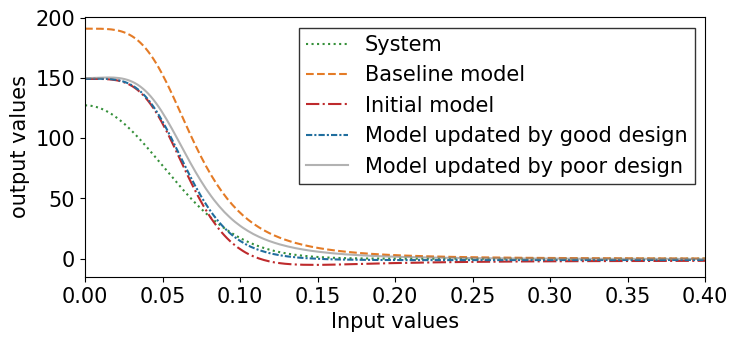

In [11]:
x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
array_nn = model.apply(params0, xy_combined)
array_nn_5 = model.apply(params5, xy_combined)
array_nn_7 = model.apply(params7, xy_combined)

exponent_internal = ((x - 0.0) ** 2 + (y - 0.0) ** 2)
factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
plt.figure(figsize=(8, 0.45*7.5))
# Directly use jnp arrays in plotting


plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_exponent.squeeze(), color = np.array([53,144,58])/255, label='System',linestyle=':')
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_reciprocal.squeeze(), color = np.array([228,123,38])/255,label='Baseline model',linestyle='--')
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn.squeeze() + array_reciprocal.squeeze()), 
         label='Initial model',color = np.array([190,42,44])/255, linestyle='-.')

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_5.squeeze() + array_reciprocal.squeeze()), 
         label='Model updated by good design',color = np.array([32,110,158])/255, linestyle=(0, (3, 1, 1, 1)))

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_7.squeeze() + array_reciprocal.squeeze()), 
         label='Model updated by poor design',color = 'grey', linestyle='-',alpha=0.6)


plt.xlabel('input')
plt.ylabel('output values')# of source/network')
plt.xlabel('Input values')# of source/network')

plt.xlim([0,0.4])
#plt.legend()
#intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
#plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

font_size = 15
plt.rcParams.update({'font.size': font_size})

legend = plt.legend(borderpad=0.05,loc='upper right', bbox_to_anchor=(0.99, 0.975),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")

#plt.savefig('combined network shape.png', dpi=600, bbox_inches='tight')
plt.show()

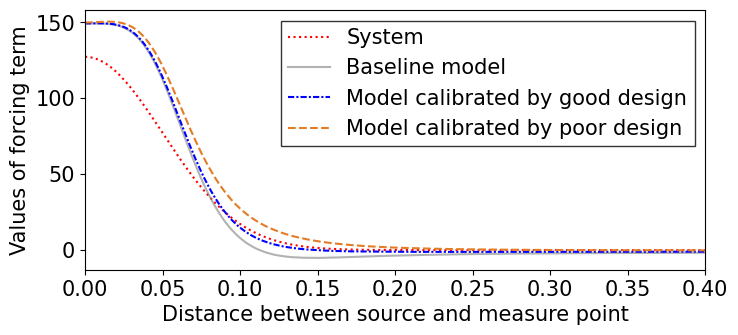

In [12]:
x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
array_nn = model.apply(params0, xy_combined)
array_nn_5 = model.apply(params5, xy_combined)
array_nn_7 = model.apply(params7, xy_combined)

exponent_internal = ((x - 0.0) ** 2 + (y - 0.0) ** 2)
factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
plt.figure(figsize=(8, 0.45*7.5))
# Directly use jnp arrays in plotting


plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_exponent.squeeze(), color = 'r', label='System',linestyle=':')#,alpha=0.6)
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn.squeeze() + array_reciprocal.squeeze()), 
         color = 'grey',label='Baseline model',linestyle='-',alpha=0.6)

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_5.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by good design',color = 'b', linestyle=(0, (3, 1, 1, 1)))

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_7.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by poor design',color = np.array([228,123,38])/255, linestyle='--')


plt.xlabel('Distance between source and measure point')
plt.ylabel('Values of forcing term')# of source/network')

plt.xlim([0,0.4])
#plt.yscale('log')
#plt.yscale('symlog', linthresh=1)

#plt.legend()
#intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
#plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

font_size = 15
plt.rcParams.update({'font.size': font_size})

legend = plt.legend(borderpad=0.05,loc='upper right', bbox_to_anchor=(0.99, 0.975),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")

#plt.savefig('combined network shape.png', dpi=600, bbox_inches='tight')
plt.show()

In [32]:
np.min(array_nn.squeeze() + array_reciprocal.squeeze())

Array(-5.159073, dtype=float32)

In [14]:
params

{'params': {'Dense_0': {'bias': Array([-0.44197133,  0.02552163, -0.4443446 ,  0.60672677], dtype=float32),
   'kernel': Array([[ 4.752211 ,  4.054    ,  8.240713 ,  9.606039 ],
          [-2.91765  ,  5.107953 , -7.9847093, -8.97204  ]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.2955129 ,  1.1056229 ,  1.3656242 ,  0.53636426], dtype=float32),
   'kernel': Array([[-0.854531 ,  2.7153423,  3.4331453,  1.0427943],
          [-4.9557853,  5.026698 ,  4.6601715,  4.9496136],
          [-3.0549269,  3.7283332, -4.048402 , -5.2841034],
          [ 4.366063 , -3.4441755,  4.610791 ,  3.3474188]], dtype=float32)},
  'Dense_2': {'bias': Array([-0.48816222], dtype=float32),
   'kernel': Array([[-10.72109 ],
          [ 10.193778],
          [ -9.885849],
          [-10.502433]], dtype=float32)}}}

In [20]:
mean1[-1]

array([ -0.52146104,   0.12957103,  -0.33174389,   0.66890742,
         4.7752462 ,   4.03717358,   8.15343301,   9.6694096 ,
        -2.86837486,   5.10309095,  -7.99962878,  -8.92907972,
        -0.32077134,   1.23970962,   1.29126378,   0.52427243,
        -0.8334189 ,   2.84243452,   3.38943812,   1.05848406,
        -5.02531799,   4.86700831,   4.86149063,   4.90754146,
        -3.09341009,   3.93218046,  -4.27620039,  -5.2720132 ,
         4.30035336,  -3.30683088,   4.44909459,   3.28997737,
        -0.48005846, -10.70295324,  10.23307912,  -9.83478319,
       -10.5653538 ])

In [17]:
reconstruct_dict_to_array(params_back)

Array([ -0.5034,  -0.028 ,  -0.3198,   0.4847,   4.8153,   4.1794,
         8.2351,   9.6484,  -2.8456,   5.2352,  -8.022 ,  -9.1204,
        -0.4493,   1.2653,   1.2336,   0.4221,  -0.7218,   2.88  ,
         3.2308,   1.1351,  -5.0888,   4.8622,   4.7844,   5.0217,
        -2.9412,   3.9048,  -4.2149,  -5.2085,   4.3755,  -3.2684,
         4.4775,   3.3922,  -0.3442, -10.59  ,  10.0693, -10.0099,
       -10.6412], dtype=float32)

Checkpoint data loaded successfully.
264.2229


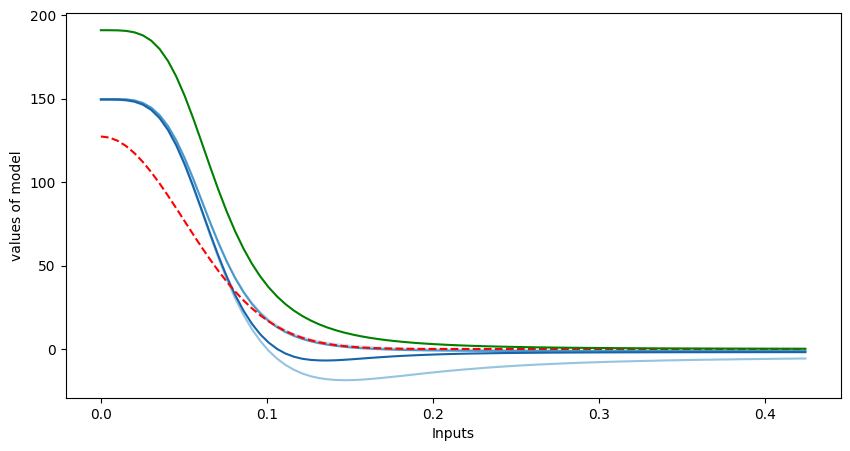

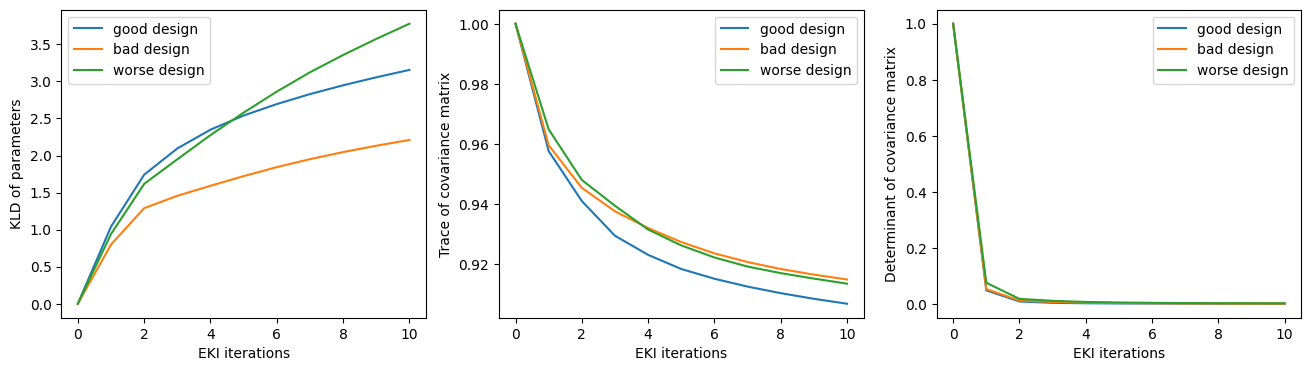

In [148]:

checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage3_test5/checkpoint_i_10_j_2.pkl' 

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_9 = checkpoint_data['params_trajectory'] # worse


params9 = reconstruct_array_to_dict(np.mean(result_matrix_design_9[-1], axis=0),params)
show_nn_trajectory([params0,params5, params7, params9], model2, 'Blues', center_x=0, center_y=0, size=85)

u_design_9 = sealed_convection_diffusion_nn(params9, d_start4, estimated_center, stage, model2)[1][100:151,100:151]
print(np.sum((u_t - u_design_9)**2))


mean_ori = np.mean(result_matrix_design_9[0],axis=0)
mean_ori_centered = result_matrix_design_9[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory9 = np.zeros(ensemble_step+1)
kld_trajectory9[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before9 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_9 = np.zeros(ensemble_step+1)
covar_trace_9[0] = np.trace(var_ori)
covar_det_9 = np.zeros(ensemble_step+1)
covar_det_9[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_9[i],axis=0)
    mean_current_centered = result_matrix_design_9[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory9[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before9[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_9[i] = np.trace(var_current)
    covar_det_9[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


fig, axes = plt.subplots(1,3,figsize=(16,4))

axes[0].plot(kld_trajectory5, label = 'good design')
axes[0].plot(kld_trajectory7, label = 'bad design')
axes[0].plot(kld_trajectory9, label = 'worse design')
axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('KLD of parameters')
axes[0].legend()


axes[1].plot(covar_trace_5/covar_trace_5[0], label = 'good design')
axes[1].plot(covar_trace_7/covar_trace_7[0], label = 'bad design')
axes[1].plot(covar_trace_9/covar_trace_9[0], label = 'worse design')
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('Trace of covariance matrix')
axes[1].legend()


axes[2].plot(covar_det_5/covar_det_5[0], label = 'good design')
axes[2].plot(covar_det_7/covar_det_7[0], label = 'bad design')
axes[2].plot(covar_det_9/covar_det_9[0], label = 'worse design')
axes[2].set_xlabel('EKI iterations')
axes[2].set_ylabel('Determinant of covariance matrix')
axes[2].legend()

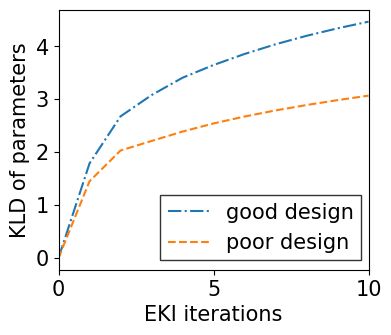

In [12]:
plt.figure(figsize=(4, 0.45*7.5))
plt.plot(kld_trajectory5, linestyle = '-.', label = 'good design')
plt.plot(kld_trajectory7, linestyle = '--', label = 'poor design')
plt.xlim([0,10])
plt.xticks([0,5,10])
plt.xlabel('EKI iterations')
plt.ylabel('KLD of parameters')
plt.legend()
legend = plt.legend(borderpad=0.05,loc='lower right', bbox_to_anchor=(0.99, 0.02),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")
#plt.savefig('KLD of parameter of NN case.png', dpi=600, bbox_inches='tight')
plt.show()

total loss  13.758534 82.472786 369.63132
local loss  0.10516035 0.2618816 8.464962


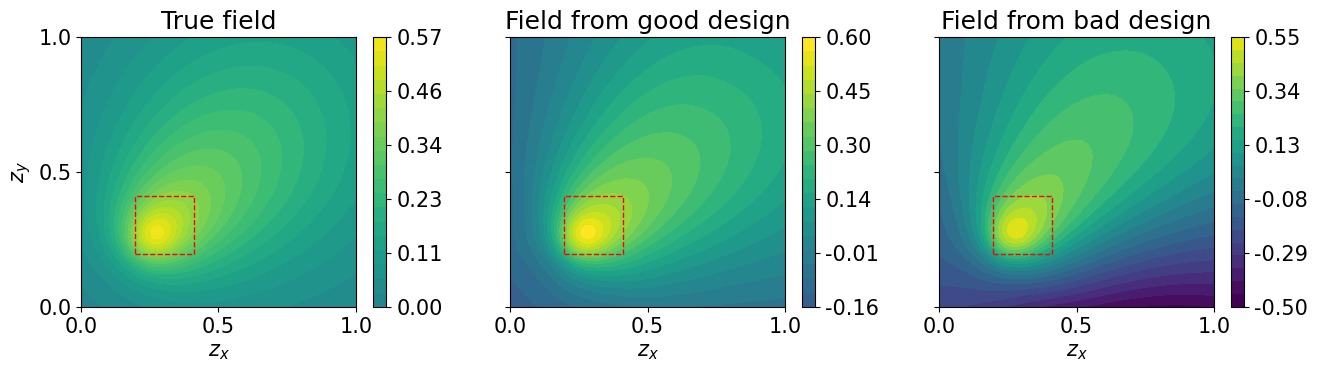

In [18]:
import matplotlib.patches as patches
# 需要指定当前的stage
stage = 2

u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
print('total loss ',np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2))
print('local loss ',np.sum(((u_t - u_design_5)**2)[10:21,10:21]),np.sum(((u_t - u_design_7)**2)[11:21,11:21]),np.sum(((u_t - u_design_8)**2)[11:21,11:21]))

# 找到所有数据的全局最小值和最大值
vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# 创建子图
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.5))
plt.subplots_adjust(wspace=0.25)


# Plot contourf images with shared vmin and vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20)
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20)
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20)

# Create rectangles with normalized coordinates
rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[0].set_title('True field')
axes[0].add_patch(rect)

rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[1].set_title('Field from good design')
axes[1].add_patch(rect)

rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[2].set_title('Field from bad design')
axes[2].add_patch(rect)

# Set xlim and ylim for all axes
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5,1.0])
    ax.set_xlabel('$z_x$')
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_ylabel('$z_y$')
    else:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_yticklabels([])


for ax, c in zip(axes, [c1, c2, c3]):
    colorbar = fig.colorbar(c, ax=ax)
    
    # 读取当前颜色条的 vmin 和 vmax
    vmin, vmax = colorbar.vmin, colorbar.vmax
    
    # 生成5个均匀分布的刻度
    ticks = np.linspace(vmin, vmax, 6)
    
    # 设置颜色条的刻度和格式化标签，保留两位小数
    colorbar.set_ticks(ticks)
    tick_labels = [f'{tick:.2f}' for tick in ticks]
    colorbar.set_ticklabels(tick_labels)
    
#plt.savefig('predict field with updated nn.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
print('total loss ',np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2))
print('total relative loss ',np.sum(((u_t - u_design_5)/u_t)**2),np.sum(((u_t - u_design_7)/u_t)**2),np.sum(((u_t - u_design_8)/u_t)**2))

total loss  13.758534 82.472786 369.63132
total relative loss  2708.4824 14525.6 50443.68


In [29]:
print('total loss ',np.sum((u_t - u_design_5)**2)/51/51,np.sum((u_t - u_design_7)**2)/51/51,np.sum((u_t - u_design_8)**2)/51/51)

total loss  0.005289709508441953 0.03170810686263246 0.1421112330406274


In [28]:
np.sum(np.abs(u_t - u_design_5))/np.sum(np.abs(u_t)),np.sum(np.abs(u_t - u_design_7))/np.sum(np.abs(u_t)),np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t))

(0.29763433, 0.664508, 1.5530363)

In [174]:
colorbar1 = fig.colorbar(c1, ax=axes[0])
colorbar1.vmax

0.6

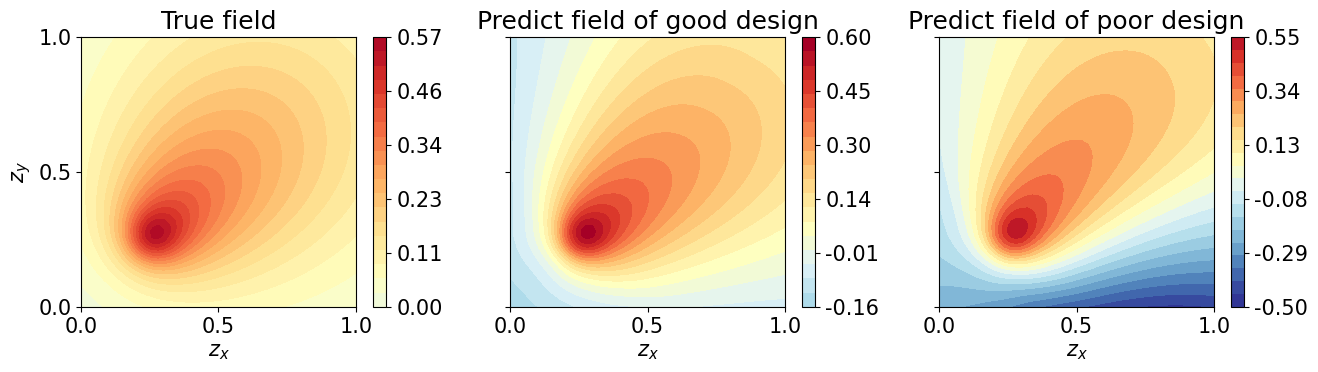

In [14]:
# 创建子图
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.5))
plt.subplots_adjust(wspace=0.25)

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# Plot contourf images with shared vmin and vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')#'YlGnBu_r'
# Create rectangles with normalized coordinates
axes[0].set_title('True field')

axes[1].set_title('Predict field of good design')

axes[2].set_title('Predict field of poor design')

# Set xlim and ylim for all axes

# Set xlim and ylim for all axes
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5,1.0])
    ax.set_xlabel('$z_x$')
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_ylabel('$z_y$')
    else:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_yticklabels([])


for ax, c in zip(axes, [c1, c2, c3]):
    colorbar = fig.colorbar(c, ax=ax)
    
    # 读取当前颜色条的 vmin 和 vmax
    vmin, vmax = colorbar.vmin, colorbar.vmax
    
    # 生成5个均匀分布的刻度
    ticks = np.linspace(vmin, vmax, 6)
    
    # 设置颜色条的刻度和格式化标签，保留两位小数
    colorbar.set_ticks(ticks)
    tick_labels = [f'{tick:.2f}' for tick in ticks]
    colorbar.set_ticklabels(tick_labels)

#plt.savefig('predict field with updated nn.png', dpi=600, bbox_inches='tight')
plt.show()

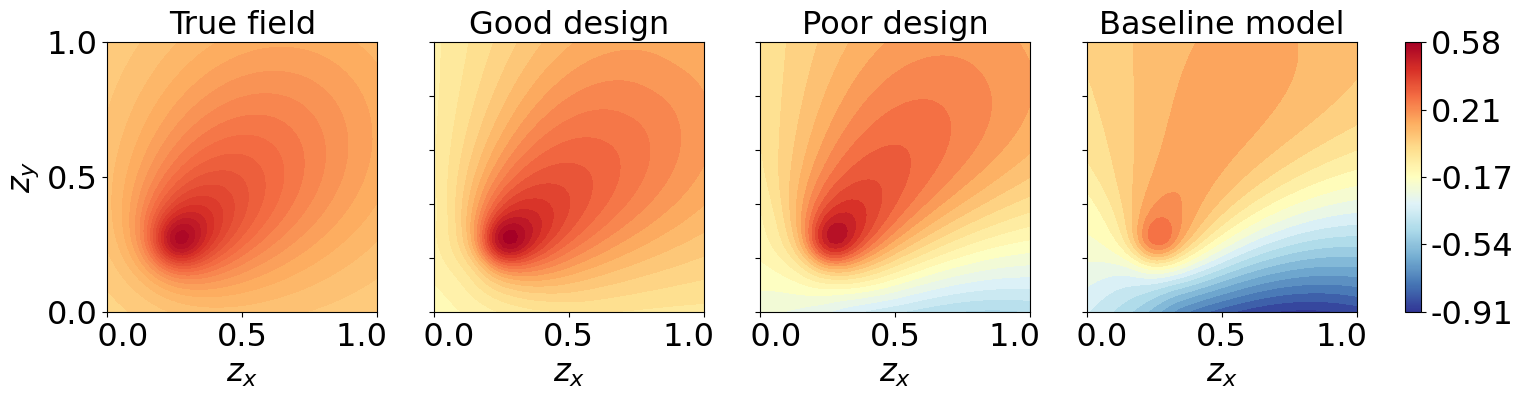

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 创建子图
fig, axes = plt.subplots(1, 4, figsize=(4.03*4, 3.5))  # 调整figsize
fig.subplots_adjust(wspace=0.21)  # 调整子图间距

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7), np.min(u_design_8))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7), np.max(u_design_8))

fontsize = 23
cmap = 'RdYlBu_r'  # 使用相同的颜色图

# 自定义刻度格式化函数
def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.5:
        return '0.5'  # 向左移动
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

# 绘制contourf图像，设置vmin和vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c4 = axes[3].contourf(np.linspace(0, 1, u_design_8.shape[0]), np.linspace(0, 1, u_design_8.shape[1]), u_design_8.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

# 设置标题
axes[0].set_title('True field', fontsize=fontsize)
axes[1].set_title('Good design', fontsize=fontsize)
axes[2].set_title('Poor design', fontsize=fontsize)
axes[3].set_title('Baseline model', fontsize=fontsize)

# 统一设置xlim、ylim和刻度
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))  # 自定义刻度格式
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)  # 设置 y 轴刻度标签的字体大小
    else:
        ax.set_yticklabels([])

# 设置颜色条
cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # 设置颜色条位置
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)

## 添加图例
#plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
#legend = plt.legend(
#    loc='center',
#    bbox_to_anchor=(0.527, 1.1),
#    ncol=3,
#    frameon=True,
#    framealpha=1,
#    edgecolor='black',
#    fontsize=fontsize,
#    borderpad=0.05, handlelength=0.5,
#    bbox_transform=fig.transFigure
#)
#legend.get_frame().set_edgecolor('black')
#legend.get_frame().set_linewidth(1)
#legend.get_frame().set_boxstyle("Square")

# 保存图片
#plt.savefig('predict_field_with_updated_nn.png', dpi=600, bbox_inches='tight')
plt.show()


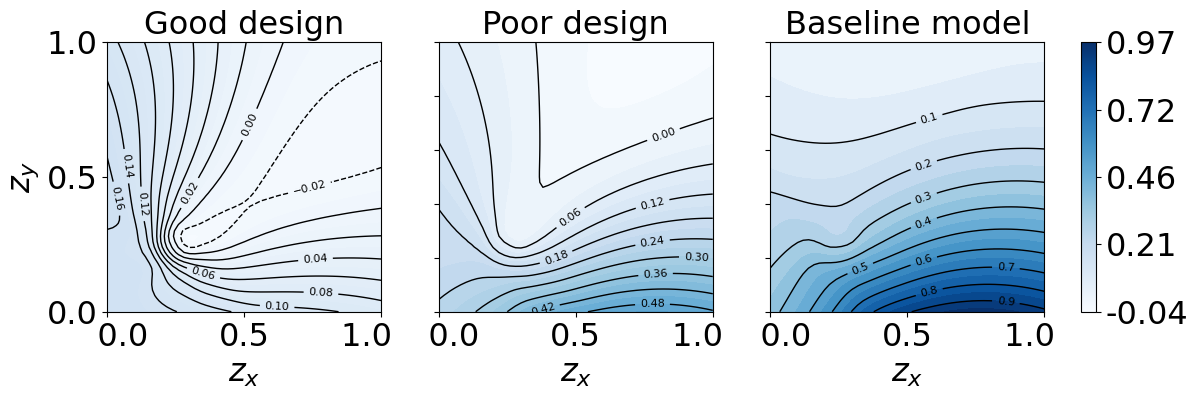

In [213]:
# 创建子图，调整figsize和wspace
fig, axes = plt.subplots(1, 3, figsize=(4.03*3, 3.5))  
fig.subplots_adjust(wspace=0.21)  

vmin = min(np.min(u_t - u_design_5), np.min(u_t - u_design_7), np.min(u_t - u_design_8))
vmax = max(np.max(u_t - u_design_5), np.max(u_t - u_design_7), np.max(u_t - u_design_8))

fontsize = 23
cmap = 'Blues'  # 颜色图与前面一致

# 自定义刻度格式化函数
def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.5:
        return '0.5'  # 向左移动
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

# 绘制 contourf 图像并设置 vmin 和 vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

# 绘制等高线并标记所有等高线的值
contour1 = axes[0].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, levels=10, colors='black', linewidths=1)
contour2 = axes[1].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, levels=10, colors='black', linewidths=1)
contour3 = axes[2].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, levels=10, colors='black', linewidths=1)

# 给等高线标注值
axes[0].clabel(contour1, inline=True, fontsize=8)
axes[1].clabel(contour2, inline=True, fontsize=8)
axes[2].clabel(contour3, inline=True, fontsize=8)

# 设置标题、标签、刻度
axes[0].set_title('Good design', fontsize=fontsize)
axes[1].set_title('Poor design', fontsize=fontsize)
axes[2].set_title('Baseline model', fontsize=fontsize)

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))  # 自定义刻度格式
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
    else:
        ax.set_yticklabels([])

# 添加颜色条
cbar_ax = fig.add_axes([0.93, 0.11, 0.013, 0.77])  # 调整颜色条的位置
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)


# 保存图片
plt.savefig('design_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

In [103]:
print((u_t - u_design_5)[12, 12], (u_t - u_design_7)[12, 12])

0.015369177 0.07912126


In [113]:
u_t = sealed_convection_diffusion_true(d_start1, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params7, d_start1, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start1, center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(37.039154, 145.35797)